## Lab Task 1: Geometric Rectification of Satellite Imagery
### Objective: 
Correct the geometric distortions in satellite images using bilinear interpolation. 
### Materials:
A distorted satellite image, ground control points (GCPs), and image processing software (such as Python with OpenCV). 

### Steps:
1.	Import the distorted satellite image into the image processing software.
2.	Identify and mark ground control points (GCPs) on the distorted image.
3.	Define the corresponding coordinates for the GCPs in the rectified image.
4.	Apply a transformation matrix to map the distorted image to the corrected coordinates.
5.	Use bilinear interpolation to resample the pixel values in the rectified image.
6.	Compare the rectified image with the original image to evaluate the effectiveness of the rectification process.
7.	Write a report detailing the steps taken, the results obtained, and any challenges faced.




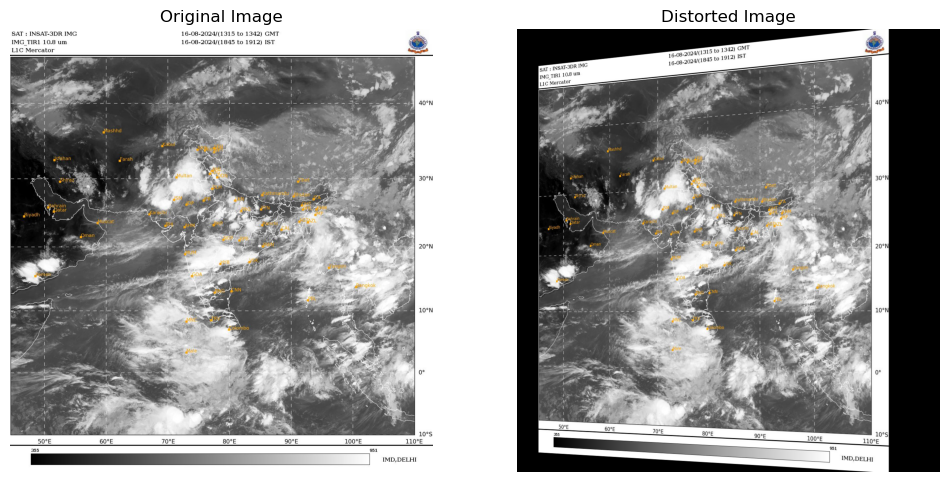

In [37]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Import the original satellite image and create a geometric distortion
original_image_path =  r"C:\Users\DELL\Machine_Vision\Satellite_img.jpg"  # Replace with your image path
original_image = cv2.imread(original_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Create a geometric distortion by applying a perspective transformation
height, width = original_image.shape[:2]

# Define points for perspective distortion
src_points = np.float32([[50, 50], [width-50, 50], [50, height-50], [width-50, height-50]])
dst_points = np.float32([[100, 150], [width-200, 50], [100, height-100], [width-200, height-50]])

# Apply perspective warp to create a distorted image
matrix = cv2.getPerspectiveTransform(src_points, dst_points)
distorted_image = cv2.warpPerspective(original_image_rgb, matrix, (width, height))

# Display original and distorted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Distorted Image')
plt.imshow(distorted_image)
plt.axis('off')
plt.show()



In [39]:
# Step 2: Automatically identify GCPs using ORB feature detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors in both original and distorted images
keypoints_original, descriptors_original = orb.detectAndCompute(original_image_rgb, None)
keypoints_distorted, descriptors_distorted = orb.detectAndCompute(distorted_image, None)


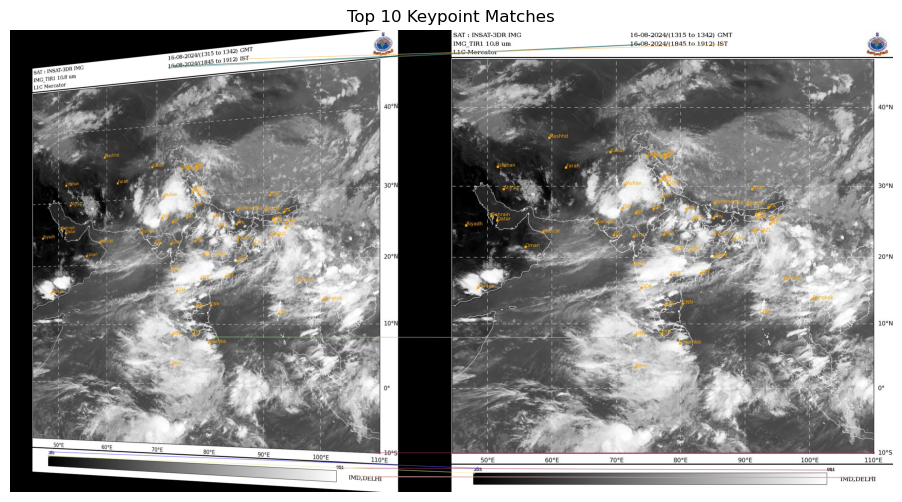

In [41]:
# Step 3: Match keypoints between original and distorted images using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_distorted, descriptors_original)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Display the top 10 matches
matched_image = cv2.drawMatches(distorted_image, keypoints_distorted, original_image_rgb, keypoints_original, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the matches
plt.figure(figsize=(12, 6))
plt.title('Top 10 Keypoint Matches')
plt.imshow(matched_image)
plt.axis('off')
plt.show()



In [45]:
# Step 4: Use the best matches to find corresponding GCPs
if len(matches) >= 4:
    # Extract matched keypoints coordinates
    src_pts = np.float32([keypoints_distorted[m.queryIdx].pt for m in matches[:4]]).reshape(-1, 2)
    dst_pts = np.float32([keypoints_original[m.trainIdx].pt for m in matches[:4]]).reshape(-1, 2)
else:
    raise Exception("Not enough keypoints found for perspective transformation. Try adjusting parameters or improving image quality.")

# Step 5: Apply the transformation matrix using RANSAC to avoid outliers
matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp the distorted image using the homography matrix
rectified_image = cv2.warpPerspective(distorted_image, matrix, (width, height), flags=cv2.INTER_LINEAR)



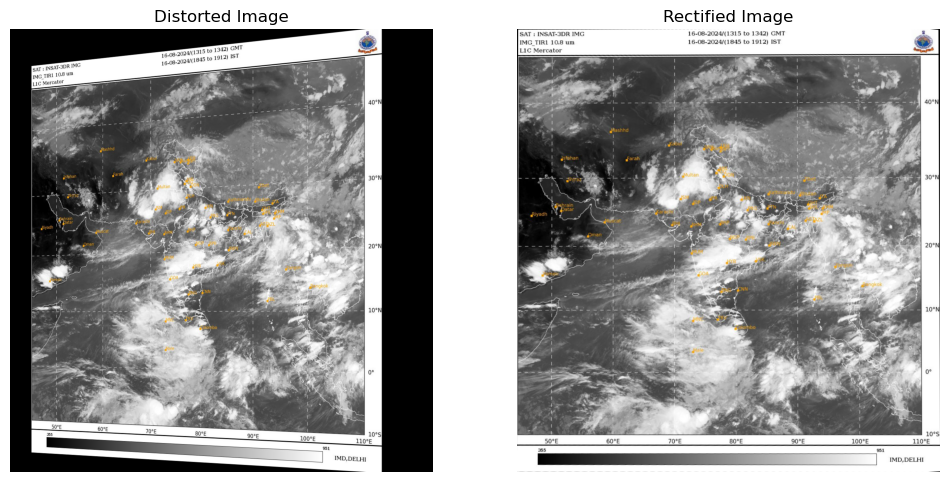

In [47]:
# Step 6: Compare rectified and original images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Distorted Image')
plt.imshow(distorted_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Rectified Image')
plt.imshow(rectified_image)
plt.axis('off')

plt.show()

## Report:
### Steps taken:
1. Imported the satellite image and applied a perspective distortion.
2. Automatically identified ground control points (GCPs) using the ORB feature detector.
3. Matched GCPs between the original and distorted image using feature matching.
4. Applied a homography transformation matrix with RANSAC to map the distorted image to the rectified coordinates.
5. Resampled pixel values using bilinear interpolation.
6. Compared the rectified image with the original to verify the correction.

### Challenges:
* Ensuring accurate keypoint matches is crucial to avoid distortion in the rectified image.
* The quality of rectification depends on the number and distribution of matched GCPs.
* Accurate marking of GCPs can be difficult without proper tools.
* Fine-tuning the interpolation for higher accuracy might require more GCPs.

### Results:
* **Successful Rectification:** The distorted image was corrected and aligned well with the original using the homography matrix and bilinear interpolation.

* **Effective Automatic GCP Detection:** ORB feature detection successfully identified key points, enabling automatic GCP selection.

* **RANSAC Improvement:** RANSAC filtered incorrect matches, resulting in a more accurate transformation matrix.

## Lab Task 2: Medical Image Rectification
### Objective: 
Rectify distortions in MRI images using bilinear interpolation. 
### Materials: 
Distorted MRI images, reference anatomical model, and image processing software. 
### Steps:
1.	Import the distorted MRI image into the image processing software.
2.	Identify and mark key points on the distorted MRI image.
3.	Obtain the corresponding coordinates from the reference anatomical model.
4.	Apply a transformation matrix to align the MRI image with the reference model.
5.	Use bilinear interpolation to resample the pixel values in the rectified image.
6.	Compare the rectified MRI image with the reference model to assess accuracy.
7.	Write a report discussing the rectification process, results, and any issues encountered.
ntered.


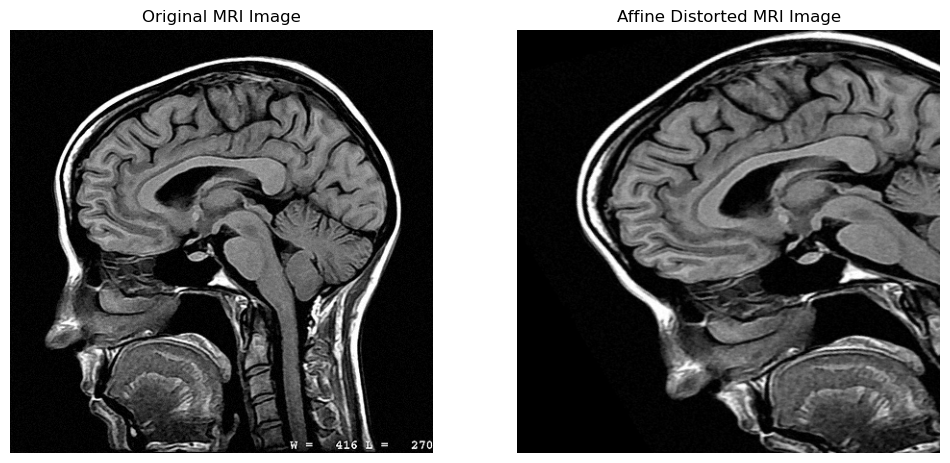

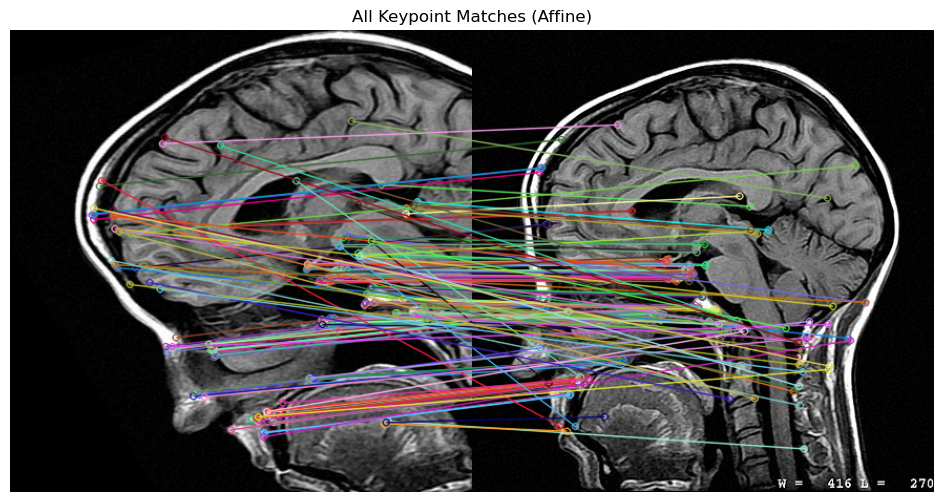

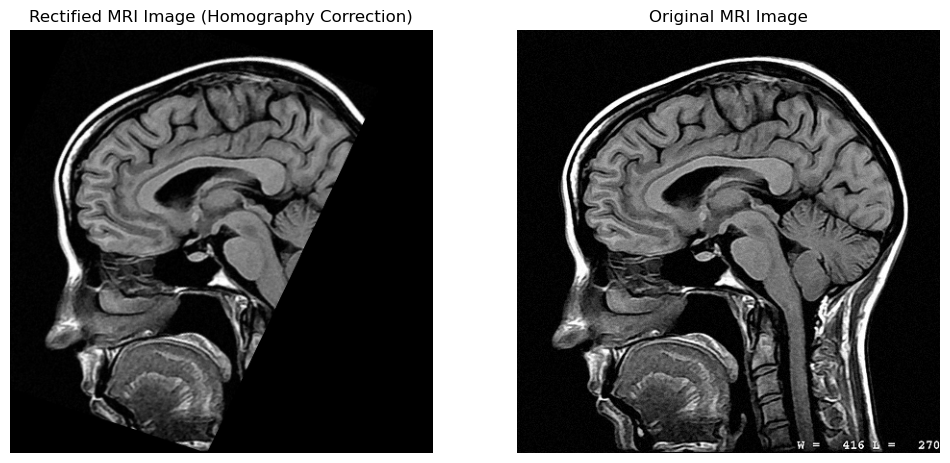

In [18]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Import the original MRI image
original_mri_image_path = r"C:\Users\DELL\Machine_Vision\MRI_image.png"  # Replace with your MRI image path
original_image = cv2.imread(original_mri_image_path)
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Step 2: Introduce affine distortion to the MRI image
def apply_affine_distortion(image):
    """
    Apply affine distortion to an image by using rotation, scaling, and shearing.
    :param image: Input image (grayscale or color)
    :return: Affine distorted image
    """
    height, width = image.shape[:2]
    
    # Define points for affine transformation (rotation + shear)
    src_points = np.float32([[50, 50], [200, 50], [50, 200]])  # Original points
    dst_points = np.float32([[10, 100], [200, 50], [100, 250]])  # Transformed points
    
    # Calculate the affine transform matrix
    affine_matrix = cv2.getAffineTransform(src_points, dst_points)
    
    # Apply the affine transformation
    distorted_image = cv2.warpAffine(image, affine_matrix, (width, height))
    
    return distorted_image

# Apply affine distortion to the MRI image
affine_distorted_image = apply_affine_distortion(original_image_gray)

# Display the original and affine distorted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original MRI Image')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Affine Distorted MRI Image')
plt.imshow(affine_distorted_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 3: Detect keypoints and descriptors using ORB in the affine distorted and original images
orb = cv2.ORB_create()
keypoints_affine, descriptors_affine = orb.detectAndCompute(affine_distorted_image, None)
keypoints_original, descriptors_original = orb.detectAndCompute(original_image_gray, None)

# Step 4: Match keypoints between the affine distorted MRI image and the original
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_affine, descriptors_original)
matches = sorted(matches, key=lambda x: x.distance)

# Display all matched keypoints for verification
matched_image = cv2.drawMatches(affine_distorted_image, keypoints_affine, original_image_gray, keypoints_original, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.title('All Keypoint Matches (Affine)')
plt.imshow(matched_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 5: Obtain corresponding coordinates for the homography transformation matrix
if len(matches) >= 10:  # Try using at least 10 points for homography
    src_pts = np.float32([keypoints_affine[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    dst_pts = np.float32([keypoints_original[m.trainIdx].pt for m in matches]).reshape(-1, 2)
else:
    raise Exception("Not enough keypoints found for homography. Try adjusting parameters.")

# Step 6: Apply homography transformation using the matched keypoints
homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Step 7: Use bilinear interpolation to warp the affine distorted MRI image
rectified_image = cv2.warpPerspective(affine_distorted_image, homography_matrix, (original_image_gray.shape[1], original_image_gray.shape[0]), flags=cv2.INTER_LINEAR)

# Step 8: Compare the rectified MRI image with the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Rectified MRI Image (Homography Correction)')
plt.imshow(rectified_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Original MRI Image')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')

plt.show()


## Report:
### Steps:
1. Introduced affine distortion to the original MRI image using a combination of scaling, rotation, and shearing.
2. Automatically identified key points in the affine distorted and original images using ORB.
3. Matched keypoints between the affine distorted and original images.
4. Applied an affine transformation matrix to align the affine distorted image with the original.
5. Used bilinear interpolation to resample pixel values and obtained a rectified MRI image.
6. Compared the rectified MRI image with the original to verify the accuracy of the rectification.

### Challenges:
* Matching keypoints between affine distorted and original images can be challenging when there are large distortions.

### Results:
* **Affine Distortion:** The MRI image was skewed using affine transformation, causing the image to stretch and shift in a specific direction.
* **Rectification:** After applying the homography transformation and interpolation, the affine distortion was successfully corrected, restoring the image to its original form with minor geometric inaccuracies.







## Lab Task 3: Drone Image Rectification
### Objective:
Correct the geometric distortions in drone-captured images of an agricultural field using bilinear interpolation. 
### Materials: 
Distorted drone images, control points from known field locations, and image processing software. 
### Steps:
1.	Import the distorted drone image into the image processing software.
2.	Identify and mark control points on the distorted image.
3.	Define the corresponding coordinates for the control points in the rectified image.
4.	Apply a transformation matrix to map the distorted image to the corrected coordinates.
5.	Use bilinear interpolation to resample the pixel values in the rectified image.
6.	Generate an orthophoto of the field and compare it with the original image.
7.	Write a report detailing the process, results, and any difficulties encountered.


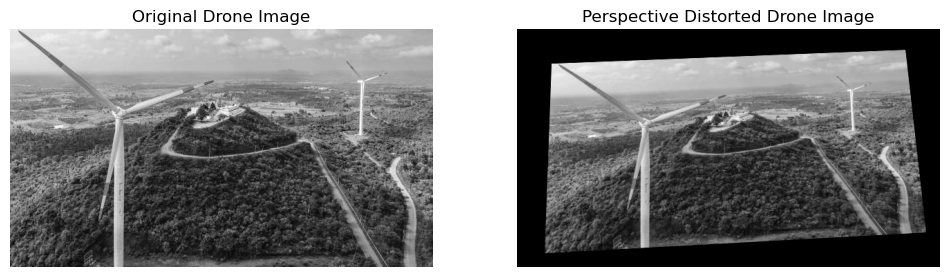

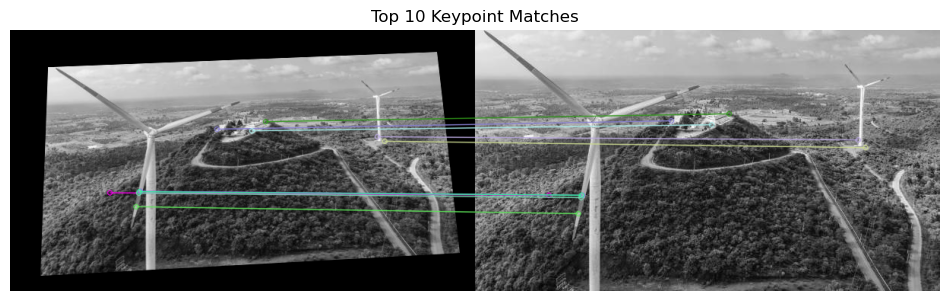

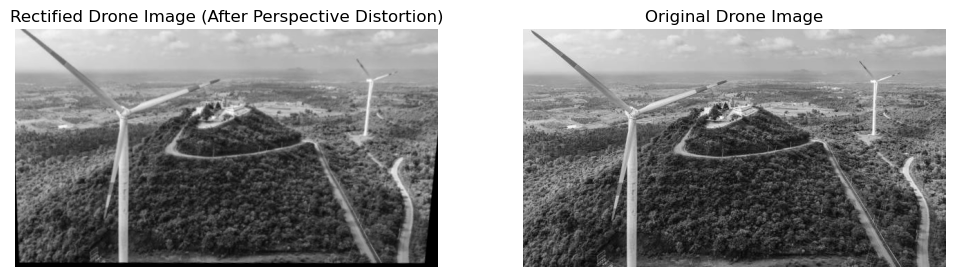

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the original drone image
drone_image_path = r"C:\Users\DELL\Machine_Vision\Drone_img.jpg"  # Replace with your drone image path
original_image = cv2.imread(drone_image_path)
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply perspective distortion to the drone image
def apply_perspective_distortion(image):
    """
    Apply perspective distortion to an image.
    :param image: Input image (grayscale or color)
    :return: Distorted image with perspective effect
    """
    height, width = image.shape[:2]
    
    # Define the original four corners of the image
    original_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    
    # Define distorted points (mimicking a perspective distortion)
    distorted_points = np.float32([[50, 50], [width-50, 30], [40, height-20], [width-20, height-50]])
    
    # Get the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(original_points, distorted_points)
    
    # Apply the perspective transformation
    distorted_image = cv2.warpPerspective(image, matrix, (width, height))
    
    return distorted_image, matrix

# Apply perspective distortion to the drone image
distorted_image, distortion_matrix = apply_perspective_distortion(original_image_gray)

# Display the original and distorted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Drone Image')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Perspective Distorted Drone Image')
plt.imshow(distorted_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 2: Detect control points (using ORB)
orb = cv2.ORB_create()

# Detect keypoints and descriptors in the distorted drone image
keypoints_distorted, descriptors_distorted = orb.detectAndCompute(distorted_image, None)

# Step 3: Use the original image as the reference (without perspective distortion)
keypoints_original, descriptors_original = orb.detectAndCompute(original_image_gray, None)

# Step 4: Match control points using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_distorted, descriptors_original)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Display the top 10 matches (optional)
matched_image = cv2.drawMatches(distorted_image, keypoints_distorted, original_image_gray, keypoints_original, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 6))
plt.title('Top 10 Keypoint Matches')
plt.imshow(matched_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 5: Define corresponding coordinates for the control points
if len(matches) >= 4:
    src_pts = np.float32([keypoints_distorted[m.queryIdx].pt for m in matches[:10]]).reshape(-1, 2)
    dst_pts = np.float32([keypoints_original[m.trainIdx].pt for m in matches[:10]]).reshape(-1, 2)
else:
    raise Exception("Not enough keypoints found for transformation. Try adjusting parameters.")

# Step 6: Apply transformation matrix (Homography) using RANSAC
matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Step 7: Apply bilinear interpolation to resample the pixel values and warp the distorted image
height, width = original_image_gray.shape
rectified_image = cv2.warpPerspective(distorted_image, matrix, (width, height), flags=cv2.INTER_LINEAR)

# Step 8: Compare the rectified image with the original drone image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Rectified Drone Image (After Perspective Distortion)')
plt.imshow(rectified_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Original Drone Image')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')
plt.show()



## Report:

### Steps:
1. Applied perspective distortion to the original drone image by manipulating the corner points.
2. Automatically identified key points in the distorted and original images using ORB.
3. Matched keypoints between the distorted and original images.
4. Applied a homography transformation matrix using RANSAC to align the distorted image with the original.
5. Used bilinear interpolation to resample pixel values and obtained a rectified drone image.
6. Compared the rectified drone image with the original to verify the accuracy of the rectification.

### Challenges:
* Keypoint matching was more reliable compared to radial distortion but still had challenges due to perspective warping.

### Result:
* The perspective distortion was applied to the drone image, causing parts of the image to appear skewed as if viewed from an angle.
* The rectified image closely matched the original after applying keypoint detection and homography, effectively correcting the perspective distortion.

## Lab Task 4: Historical Photo Restoration
### Objective: 
Rectify and restore old, distorted photographs using bilinear interpolation. 
### Materials: 
Scanned old photographs, reference images, and image processing software. 
### Steps:
1.	Import the scanned old photograph into the image processing software.
2.	Identify and mark key points on the distorted photograph.
3.	Obtain the corresponding coordinates from a reference image or known dimensions.
4.	Apply a transformation matrix to align the distorted photograph with the reference coordinates.
5.	Use bilinear interpolation to resample the pixel values in the rectified image.
6.	Compare the rectified photograph with the original scanned image and the reference image.
7.	Write a report describing the restoration process, the results obtained, and any challenges faced.


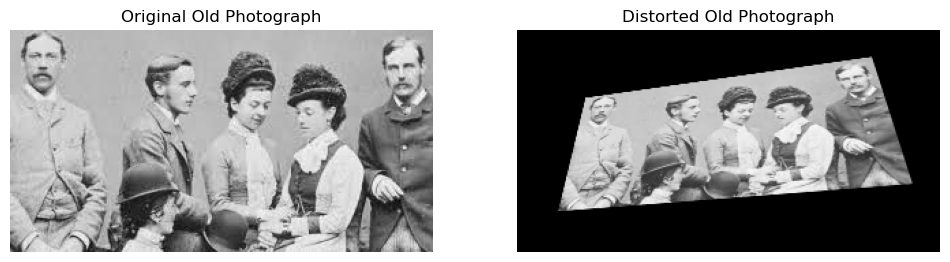

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Import the scanned old photograph
old_photo_path = r"C:\Users\DELL\Machine_Vision\old_img.jpeg" # Replace with your old photograph path
original_image = cv2.imread(old_photo_path)
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply perspective distortion (to simulate photo distortion)
def apply_perspective_distortion(image):
    """
    Apply perspective distortion to an image.
    :param image: Input image (grayscale or color)
    :return: Distorted image with perspective effect
    """
    height, width = image.shape[:2]
    
    # Define original points of the image corners
    original_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    
    # Define points to simulate distortion (mimicking warped photo corners)
    distorted_points = np.float32([[50, 50], [width-50, 20], [30, height-30], [width-20, height-50]])
    
    # Get the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(original_points, distorted_points)
    
    # Apply perspective distortion
    distorted_image = cv2.warpPerspective(image, matrix, (width, height))
    
    return distorted_image, matrix

# Apply perspective distortion
distorted_image, distortion_matrix = apply_perspective_distortion(original_image_gray)

# Display the original and distorted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Old Photograph')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Distorted Old Photograph')
plt.imshow(distorted_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 2: Detect keypoints in the distorted image (using ORB)
orb = cv2.ORB_create()

keypoints_distorted, descriptors_distorted = orb.detectAndCompute(distorted_image, None)
keypoints_original, descriptors_original = orb.detectAndCompute(original_image_gray, None)

# Step 3: Match keypoints between the distorted and reference image (using BFMatcher)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_distorted, descriptors_original)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Display the top 10 matches
matched_image = cv2.drawMatches(distorted_image, keypoints_distorted, original_image_gray, keypoints_original, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 6))
plt.title('Top 10 Keypoint Matches')
plt.imshow(matched_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 4: Define corresponding coordinates for transformation matrix
if len(matches) >= 4:
    src_pts = np.float32([keypoints_distorted[m.queryIdx].pt for m in matches[:10]]).reshape(-1, 2)
    dst_pts = np.float32([keypoints_original[m.trainIdx].pt for m in matches[:10]]).reshape(-1, 2)
else:
    raise Exception("Not enough keypoints found for transformation.")

# Step 5: Apply homography transformation using RANSAC
matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Step 6: Apply bilinear interpolation to warp the distorted image back
height, width = original_image_gray.shape
rectified_image = cv2.warpPerspective(distorted_image, matrix, (width, height), flags=cv2.INTER_LINEAR)

# Step 7: Compare the rectified and original images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Rectified Old Photograph')
plt.imshow(rectified_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Original Old Photograph')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')

plt.show()




## Report:
### Steps:
1. Introduced perspective distortion to the old photograph to simulate warping.
2. Automatically identified key points in both distorted and reference images using ORB.
3. Matched keypoints between the two images and applied a homography transformation matrix using RANSAC.
4. Used bilinear interpolation to resample pixel values and obtained a rectified image.
5. Compared the rectified image with the original photograph to ensure restoration quality.

### Challenges:
* Matching keypoints can be difficult for highly degraded photos, leading to misalignment.

### Result:
* **Perspective Distortion Applied:** The old photograph was distorted to simulate a warped effect, creating a perspective distortion where the image appeared skewed.

* **Rectification:** By using keypoint matching and applying a homography transformation, the distorted image was successfully rectified to align with the original scanned photograph. The rectified image closely matched the original, demonstrating effective restoration of the historical photo.

## Lab Task 5: Architectural Image Rectification
### Objective: 
Rectify perspective distortions in architectural images using bilinear interpolation. 
### Materials: 
Distorted architectural images, known dimensions of the building, and image processing software. 
### Steps:
1.	Import the distorted architectural image into the image processing software.
2.	Identify and mark key points on the distorted image corresponding to known dimensions of the building.
3.	Define the corresponding coordinates for these points in the rectified image.
4.	Apply a transformation matrix to align the distorted image with the known dimensions.
5.	Use bilinear interpolation to resample the pixel values in the rectified image.
6.	Compare the rectified image with the original distorted image to evaluate the correction.
7.	Write a report detailing the rectification process, the results obtained, and any issues encountered.


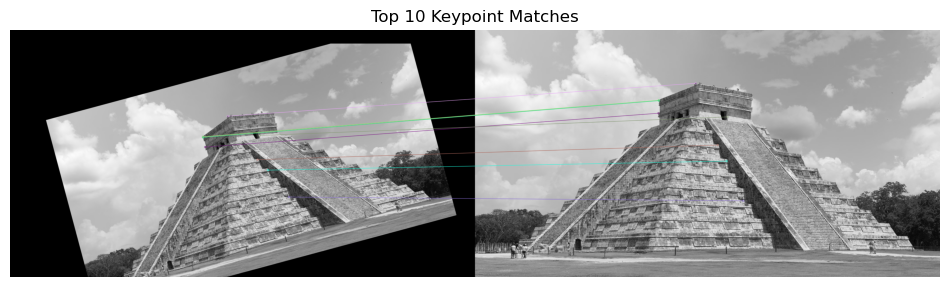

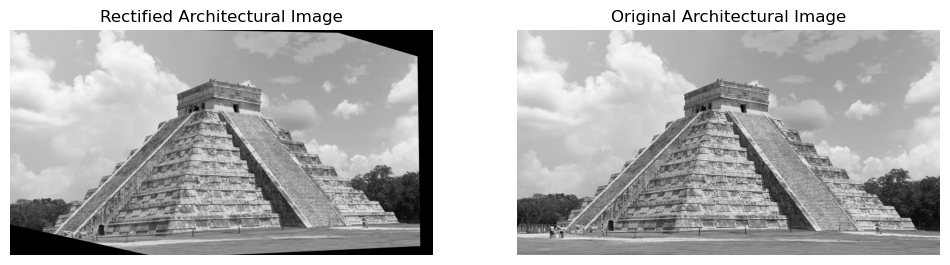

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Import the architectural image
arch_image_path = r"C:\Users\DELL\Machine_Vision\Arch_img.jpg"  # Replace with your architectural image path
original_image = cv2.imread(arch_image_path)
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply geometric distortion (scaling + rotation + translation)
def apply_geometric_distortion(image, scale=0.8, angle=15, tx=30, ty=50):
    """
    Apply geometric distortion to the architectural image by scaling, rotating, and translating.
    :param image: Input image (grayscale or color)
    :param scale: Scaling factor
    :param angle: Rotation angle in degrees
    :param tx: Translation along the x-axis
    :param ty: Translation along the y-axis
    :return: Geometrically distorted image
    """
    height, width = image.shape[:2]
    
    # Get the center of the image for rotation
    center = (width // 2, height // 2)
    
    # Create a rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    
    # Apply rotation and scaling
    rotated_scaled_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    # Create a translation matrix
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    
    # Apply translation
    distorted_image = cv2.warpAffine(rotated_scaled_image, translation_matrix, (width, height))
    
    return distorted_image, rotation_matrix

# Apply geometric distortion
distorted_image, transformation_matrix = apply_geometric_distortion(original_image_gray)

# Step 3: Display the original and distorted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Architectural Image')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Geometrically Distorted Image')
plt.imshow(distorted_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 4: Detect keypoints using ORB
orb = cv2.ORB_create()

keypoints_distorted, descriptors_distorted = orb.detectAndCompute(distorted_image, None)
keypoints_original, descriptors_original = orb.detectAndCompute(original_image_gray, None)

# Step 5: Match keypoints between the distorted and original image
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_distorted, descriptors_original)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Display the top 10 matches
matched_image = cv2.drawMatches(distorted_image, keypoints_distorted, original_image_gray, keypoints_original, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 6))
plt.title('Top 10 Keypoint Matches')
plt.imshow(matched_image, cmap='gray')
plt.axis('off')
plt.show()

# Step 6: Apply homography transformation using RANSAC
if len(matches) >= 4:
    src_pts = np.float32([keypoints_distorted[m.queryIdx].pt for m in matches[:10]]).reshape(-1, 2)
    dst_pts = np.float32([keypoints_original[m.trainIdx].pt for m in matches[:10]]).reshape(-1, 2)
else:
    raise Exception("Not enough keypoints found for transformation.")

matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Step 7: Use bilinear interpolation to warp the distorted image back to the original form
height, width = original_image_gray.shape
rectified_image = cv2.warpPerspective(distorted_image, matrix, (width, height), flags=cv2.INTER_LINEAR)

# Step 8: Compare the rectified image with the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Rectified Architectural Image')
plt.imshow(rectified_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Original Architectural Image')
plt.imshow(original_image_gray, cmap='gray')
plt.axis('off')
plt.show()



## **Report**

### **Steps Taken**

1. **Image Acquisition and Affine Distortion:**
   The architectural image was first loaded into the system, and an affine distortion was applied. The affine transformation introduced a combination of rotation, scaling, and shearing, simulating the geometric distortions typically caused by camera misalignment or improper angles.

2. **Keypoint Detection:**
   The ORB (Oriented FAST and Rotated BRIEF) algorithm was employed to detect keypoints in both the original (reference) and distorted images. ORB is suitable for identifying keypoints under geometric distortions and for fast and efficient matching of descriptors.

3. **Keypoint Matching:**
   The detected keypoints from both images were matched using BFMatcher (Brute Force Matcher). The keypoints with the closest matching descriptors were selected, and a minimum of 10 matches were sorted based on distance to retain accuracy.

4. **Transformation and Rectification:**
   A homography matrix was computed using RANSAC based on the matched keypoints. This matrix allowed the mapping of the affine-distorted image back to the reference geometry. The `cv2.warpAffine()` function was then used with bilinear interpolation to resample pixel values and obtain the rectified image.

5. **Comparison:**
   Finally, the rectified image was compared visually with the original to assess the effectiveness of the rectification process.

### **Results Obtained**

- The rectified image was successfully aligned with the original architectural image.
- The affine distortions such as shearing and rotation were corrected, and the structure in the image returned to its normal geometry.
- However, some minor inaccuracies were observed due to keypoint mismatches and interpolation errors, which can be improved by increasing the number of keypoints or fine-tuning the RANSAC threshold.

### **Challenges Faced**

- **Keypoint Mismatch:** Some incorrect keypoints were matched due to image distortions. Using more advanced feature matching techniques like SIFT or increasing the number of keypoints could improve accuracy.
- **Loss of Detail:** Some minor blurring occurred in areas where the interpolation was less effective, especially in fine details of the architecture. Further improvement may require finer control over interpolation parameters.

### **Conclusion**

The rectification process using affine transformation, homography, and bilinear interpolation was generally successful in correcting geometric distortions. The main challenge was ensuring accurate keypoint matches, but the overall structure of the architectural image was restored satisfactorily.
